In [1]:
from __future__ import division

import numpy as np
import glob
import matplotlib.pyplot as plt
import scipy.linalg as sl
from enterprise.signals.parameter import Uniform
import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals.deterministic_signals import Deterministic
import corner
from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
from enterprise_extensions.sampler import JumpProposal, get_parameter_groups, save_runtime_info

def hms_to_rad(hh, mm, ss):
    sgn = np.sign(hh)
    return sgn * (sgn * hh + mm / 60 + ss / 3600) * np.pi / 12


def dms_to_rad(dd, mm, ss):
    sgn = np.sign(dd)
    return sgn * (sgn * dd + mm / 60 + ss / 3600) * np.pi / 180


datadir ='gwhyp_sims_try/'

parfiles = sorted(glob.glob(datadir + '/*.par'))
timfiles = sorted(glob.glob(datadir + '/*.tim'))

psrs = []
for p, t in zip(parfiles, timfiles):
    psr = Pulsar(p, t)
    psrs.append(psr)
    

# find the maximum time span to set GW frequency sampling
tmin = [p.toas.min() for p in psrs]
tmax = [p.toas.max() for p in psrs]
Tspan = np.max(tmax) - np.min(tmin)

##### parameters and priors #####

# white noise parameters
# in this case we just set the value here since all efacs = 1 
# for the MDC data
#efac = parameter.Constant(1.0)

efac = parameter.Constant(1.0)


# white noise
ef = white_signals.MeasurementNoise(efac=efac)


# timing model
tm = gp_signals.TimingModel()

##########################################################################

from gw_hyp import hyp_pta_res

RA_GW = hms_to_rad(4, 0, 0)
DEC_GW = dms_to_rad(-45, 0, 0)



tref1 = (max(psr.toas)+min(psr.toas))/2


inc0=0;q0=1


def memory_block_hyp(
    cos_gwtheta=np.sin(DEC_GW),
    gwphi=RA_GW,
    psi=0,
    cos_inc=np.cos(inc0),
    log10_M=Uniform(8,10.47)("hyp_M"),
    q=q0,
    b=Uniform(50,100)("hyp_b"),
    e0=Uniform(1.1,1.3)("hyp_e"),
    log10_S=Uniform(-7,-5)("hyp_S"),
    tref=tref1):
    return Deterministic(hyp_pta_res(cos_gwtheta=cos_gwtheta,gwphi=gwphi,psi=psi,cos_inc=cos_inc
                                     ,log10_M=log10_M,q=q,b=b,e0=e0,log10_S=log10_S,tref=tref),name="hyp")


hyp = memory_block_hyp()

#############################
# full model is sum of components
model = ef + tm +hyp


# initialize PTA
pta = signal_base.PTA([model(psr) for psr in psrs])


# initial parameters
xs = {par.name: par.sample() for par in pta.params}


[observatory.C:272] Warning: Assuming site '7' means 'pks'


In [2]:
from getdist import plots, MCSamples
from getdist.gaussian_mixtures import GaussianND
import getdist
getdist.chains.print_load_details = False

In [3]:
chain = np.loadtxt('chains/mdc/open1_hyp/chain_1.txt')
ll=len(xs)
xs

{'hyp_M': 8.601395895718746,
 'hyp_S': -5.825859899269902,
 'hyp_b': 65.03675865648299,
 'hyp_e': 1.1724707213477252}

In [4]:
labels=['\log_{10} M','\log_{10} S','b','e_t']
#names=['hyp_S','hyp_b','hyp_e']

In [19]:
pct = 0.3 # percent of the chain to toss
burn = int(pct * chain.shape[0])


samples = chain[burn:,:-4]

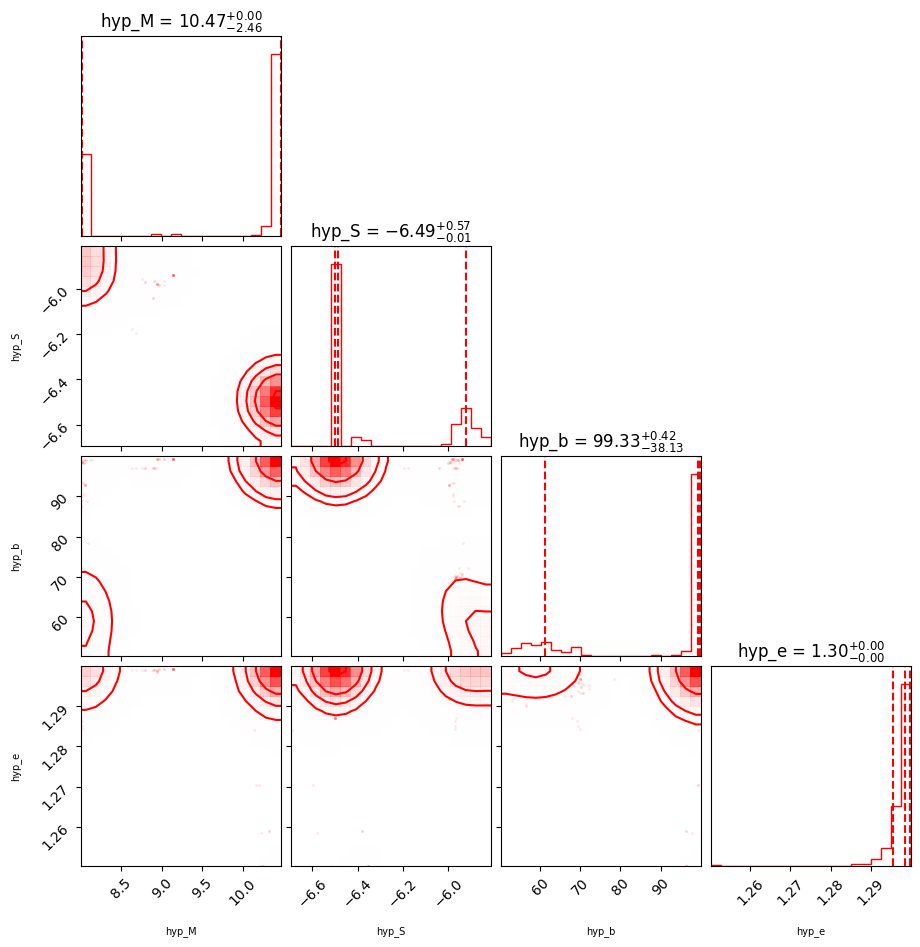

In [22]:
%matplotlib inline
fig = corner.corner(samples,labels=list(pta.param_names), label_kwargs={"fontsize": 7},smooth=2.0,color='r',
                     quantiles=(0.16, 0.5, 0.84),show_titles=True)
#plt.suptitle(psrname, fontsize=16)

plt.savefig('M_10_s_-6_b_70_e_1.15.png',dpi=300)